In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

%matplotlib inline

PATH = Path('../..').resolve()

In [18]:
import matplotlib.patches

In [3]:
from fastai import *
from fastai.vision import *

sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

seed = 12345

Mish activation loaded...
Mish activation loaded...


In [4]:
slope = lambda y, p: ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

In [5]:
a40 = pd.read_csv(f'{PATH}/results/predictions/best_a40A-34.csv')

# Results (no cross-testing)

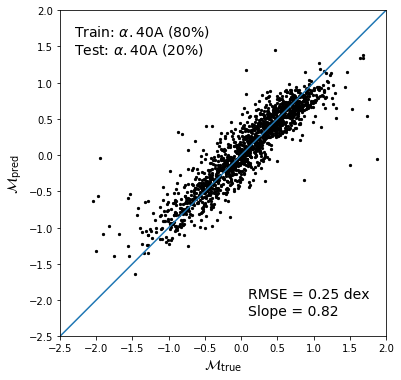

In [5]:
plt.figure(figsize=(6, 6))

plt.scatter(a40.fgas_true, a40.fgas_pred, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: $\alpha.40$A (80%)' + '\n' + r'Test: $\alpha.40$A (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((a40.fgas_pred - a40.fgas_true)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(a40.fgas_true, a40.fgas_pred):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.savefig(f'{PATH}/results/figures-updated/train_test-a40A.pdf')

In [6]:
xg = pd.read_csv(f'{PATH}/results/predictions/best_xGASS-34.csv')

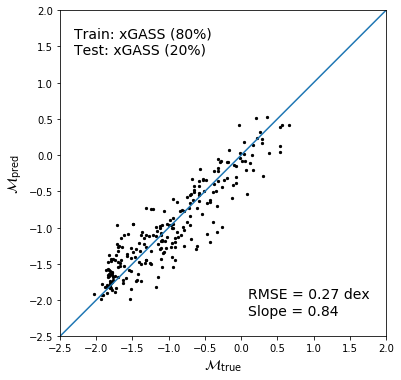

In [7]:
plt.figure(figsize=(6, 6))

plt.scatter(xg.fgas_true, xg.fgas_pred, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: xGASS (80%)' + '\n' + r'Test: xGASS (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((xg.fgas_pred - xg.fgas_true)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(xg.fgas_true, xg.fgas_pred):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.savefig(f'{PATH}/results/figures-updated/train_test-xGASS.pdf')

# Trained on $\alpha$.40A (80%) and tested on xGASS

In [41]:
image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

In [75]:
a40 = pd.read_csv(f"{PATH}/data/a40-SDSS_gas-frac.csv")

data_a40 = (
        ImageList.from_df(
            a40, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
        )
        .split_none()
        .label_from_df(cols=["logfgas"], label_cls=FloatList)
    .transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(image_stats)
)

xg = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")

data_xg = (
        ImageList.from_df(
            xg, path=PATH, folder="images-xGASS", suffix=".jpg", cols="GASS"
        )
        .split_none()
        .label_from_df(cols=["lgGF"], label_cls=FloatList)
    .transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(image_stats)
)


In [76]:
model = mxresnet50()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True)

In [77]:
learn = Learner(
    data_a40,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

In [78]:
learn.load('best_a40A-50');

set state called


In [79]:
learn.data.valid_dl = data_xg.train_dl

In [86]:
fgas_pred, fgas_true = learn.get_preds()

In [87]:
rmse_combined = ((fgas_true.flatten() - fgas_pred.flatten())**2).mean()**0.5
slope_combined = slope(fgas_true.flatten(), fgas_pred.flatten())

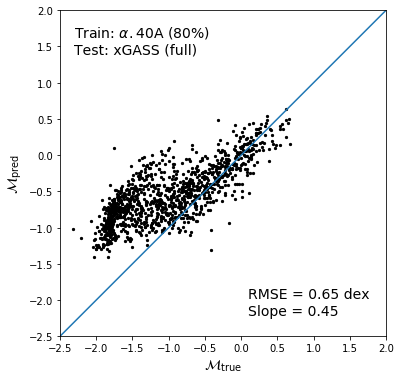

In [88]:
plt.figure(figsize=(6, 6))

plt.scatter(fgas_true, fgas_pred, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: $\alpha.40$A (80%)' + '\n' + r'Test: xGASS (full)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {rmse_combined:.2f} dex\n' + f'Slope = {slope_combined:.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.savefig(f'{PATH}/results/figures-updated/train-a40_test-xGASS.pdf')

## Repeated but with 90% bounding boxes

In [89]:
a40_lo = a40.logfgas.quantile(0.05)
a40_hi = a40.logfgas.quantile(0.95)

In [90]:
in_box = (fgas_true > a40_lo) & (fgas_true < a40_hi)

rmse_box = ((fgas_true[in_box].flatten() - fgas_pred[in_box].flatten())**2).mean()**0.5
slope_box = slope(fgas_true[in_box].flatten(), fgas_pred[in_box].flatten())

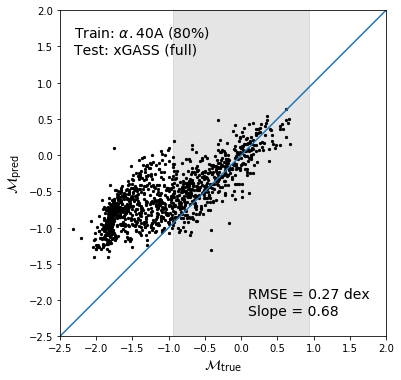

In [91]:
plt.figure(figsize=(6, 6))

plt.scatter(fgas_true, fgas_pred, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: $\alpha.40$A (80%)' + '\n' + r'Test: xGASS (full)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {rmse_box:.2f} dex\n' + f'Slope = {slope_box:.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

# bounding box
plt.axvspan(a40_lo, a40_hi, alpha=0.1, color='k')

plt.savefig(f'{PATH}/results/figures-updated/train-a40_test-xGASS_with-box.pdf')

# Train on xGASS (full) and predict on $\alpha.40$A (full)

In [92]:
model = mxresnet34()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True)

In [93]:
learn = Learner(
    data_xg,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

In [94]:
learn.load('best_xgass-34');

set state called


In [95]:
learn.data.valid_dl = data_a40.train_dl

In [96]:
fgas_pred, fgas_true = learn.get_preds()

In [97]:
rmse_combined = ((fgas_true.flatten() - fgas_pred.flatten())**2).mean()**0.5
slope_combined = slope(fgas_true.flatten(), fgas_pred.flatten())

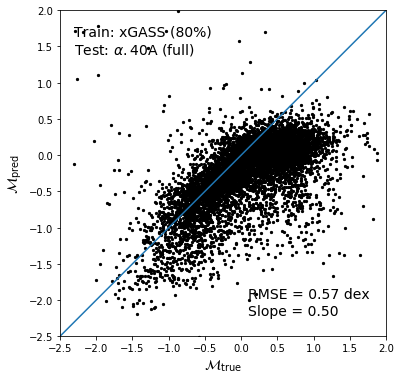

In [98]:
plt.figure(figsize=(6, 6))

plt.scatter(fgas_true, fgas_pred, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: xGASS (80%)' + '\n' + r'Test: $\alpha.40$A (full)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {rmse_combined:.2f} dex\n' + f'Slope = {slope_combined:.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.savefig(f'{PATH}/results/figures-updated/train-xGASS_test-a40A.pdf')

## Repeat but with boxes bounding the 90% distribution

In [99]:
xg_lo, xg_hi = xg.lgGF.quantile([0.05, 0.95])
in_box = (fgas_true > xg_lo) & (fgas_true < xg_hi)

rmse_box = ((fgas_true[in_box].flatten() - fgas_pred[in_box].flatten())**2).mean()**0.5
slope_box = slope(fgas_true[in_box].flatten(), fgas_pred[in_box].flatten())

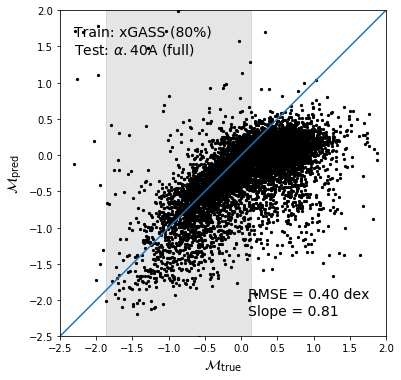

In [100]:
plt.figure(figsize=(6, 6))

plt.scatter(fgas_true, fgas_pred, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: xGASS (80%)' + '\n' + r'Test: $\alpha.40$A (full)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {rmse_box:.2f} dex\n' + f'Slope = {slope_box:.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

# with box
plt.axvspan(xg_lo, xg_hi, alpha=0.1, color='k')

plt.savefig(f'{PATH}/results/figures-updated/train-xGASS_test-a40A_with-box.pdf')

# Train on $\alpha.40$B and test on $\alpha.40$A (not in B)

In [30]:
a40B = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

In [31]:
data_a40B = (
        ImageList.from_df(
            a40B, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
        )
        .split_none()
        .label_from_df(cols=["logfgas"], label_cls=FloatList)
    .transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(image_stats)
)

In [32]:
a40A_exclusive = a40.loc[~a40.AGCNr.isin(a40B.AGCNr)]

data_a40A = (
        ImageList.from_df(
            a40A_exclusive, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
        )
        .split_none()
        .label_from_df(cols=["logfgas"], label_cls=FloatList)
    .transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(image_stats)
)

In [33]:
model = mxresnet50()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True)

In [34]:
learn = Learner(
    data_a40B,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

In [35]:
learn.data.valid_dl = data_a40A.train_dl

In [139]:
learn.fit_one_cycle(100, 10e-2)

epoch,train_loss,valid_loss,time
0,0.374756,0.577994,00:43
1,0.336402,1.311701,00:43
2,0.318474,0.497372,00:43
3,0.307777,0.342724,00:43
4,0.292386,0.369730,00:43
5,0.290819,0.312826,00:43
6,0.297688,0.454441,00:43
7,0.294487,0.655627,00:43
8,0.294881,0.399913,00:43
9,0.294440,0.441204,00:43


In [36]:
# learn.save('best_a40B-50');
learn.load('best_a40B-50');

set state called


In [37]:
fgas_pred, fgas_true = learn.get_preds()

In [38]:
rmse_combined = ((fgas_true.flatten() - fgas_pred.flatten())**2).mean()**0.5
slope_combined = slope(fgas_true.flatten(), fgas_pred.flatten())

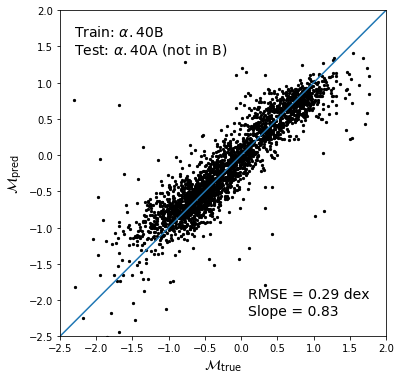

In [39]:
plt.figure(figsize=(6, 6))

plt.scatter(fgas_true, fgas_pred, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: $\alpha.40$B' + '\n' + r'Test: $\alpha.40$A (not in B)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {rmse_combined:.2f} dex\n' + f'Slope = {slope_combined:.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.savefig(f'{PATH}/results/figures-updated/train-a40B_test-a40A.pdf')

# Combined training/testing

In [40]:
image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

In [41]:
df = pd.read_csv(f"{PATH}/data/combined.csv")

src = (
    ImageList.from_df(
        df, path=PATH, folder="images-combined", suffix=".jpg", cols="id"
    )
    .split_by_rand_pct(0.2, seed=seed)
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(image_stats)
)

model = mxresnet50()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True)

In [42]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

In [58]:
learn.fit_one_cycle(100, 10e-2)

epoch,train_loss,valid_loss,time
0,0.456884,0.442989,00:55
1,0.397452,0.364480,00:54
2,0.376529,0.380990,00:54
3,0.348699,0.339169,00:54
4,0.354632,0.421087,00:54
5,0.340527,0.332732,00:54
6,0.362649,0.835996,00:54
7,0.363168,0.329516,00:54
8,0.353359,0.409434,00:54
9,0.361757,0.329872,00:54


In [43]:
# learn.save('combined-mxresnet50-100ep');
learn.load('combined-mxresnet50-100ep');

set state called


In [47]:
fgas_pred, fgas_true = learn.TTA(scale=1)

In [48]:
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2740)

In [49]:
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['id'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('id', drop=True, inplace=True)

results.to_csv(f'{PATH}/results/predictions/best_combined-100.csv')

In [50]:
rmse_combined = ((fgas_true.flatten() - fgas_pred.flatten())**2).mean()**0.5
slope_combined = slope(fgas_true.flatten(), fgas_pred.flatten())

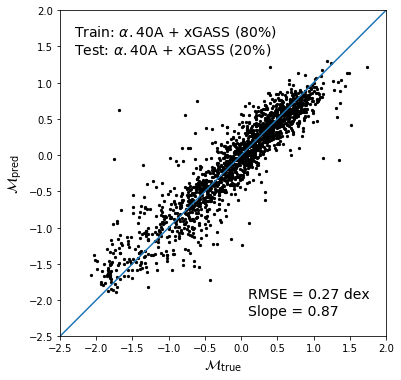

In [51]:
plt.figure(figsize=(6, 6))

plt.scatter(fgas_true, fgas_pred, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: $\alpha.40$A + xGASS (80%)' + '\n' + r'Test: $\alpha.40$A + xGASS (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {rmse_combined:.2f} dex\n' + f'Slope = {slope_combined:.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)

plt.savefig(f'{PATH}/results/figures-updated/train_test-combined.pdf')